<center><h1>Yu_Liujia_HW4</h1></center>
<br>
<br>

Name: Liujia Yu
<br>
Github Username: LesleyYu
<br>
USC ID: 4764432021

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
# import python libraries
import pandas as pd
import statistics
import os
import numpy as np
from scipy import stats
import seaborn as sns

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV, RFE, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Get the AReM Data Set

In [2]:
# reading files in several subdirectories
# get all file names
rootdir = '../../data/AReM/'
all_files = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        # Check if the file is a CSV (because there are pdf files exist)
        if file.endswith('.csv'):
            all_files.append(os.path.join(subdir, file))

print(len(all_files))

# reference: https://stackoverflow.com/questions/19587118/iterating-through-directories-with-python

# read all 88 data sets
df_list = {}    # changed to dictionary for train and test split

for file in all_files:
    try:
        if (file == "../../data/AReM/bending2/dataset4.csv"):
            df_temp = pd.read_csv(file, 
                                header = 5, 
                                names = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'], 
                                sep = ' ', 
                                index_col = False)
        else:
            df_temp = pd.read_csv(file, 
                                header = 5, 
                                names = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'])
        df_list[file] = df_temp
    except Exception as e:
        print(f"Error reading file {file}: {str(e)}")   # fail (qaq)

print(len(df_list))
print(df_list.get(all_files[0]))

88
88
       time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0       250      42.00       0.00      18.00       0.00      11.33       0.94
1       500      42.75       0.43      16.75       1.79      18.25       0.43
2       750      42.50       0.50      16.75       0.83      19.00       1.22
3      1000      43.00       0.82      16.25       0.83      18.00       0.00
4      1250      43.67       0.47      12.75       0.83      19.00       0.82
..      ...        ...        ...        ...        ...        ...        ...
474  118750      44.25       0.83      16.25       1.30      24.00       0.00
475  119000      44.00       0.71      11.00       1.00      24.00       0.00
476  119250      44.25       0.43      10.25       1.30      22.75       0.83
477  119500      43.75       0.43       7.33       2.87      21.50       0.50
478  119750      44.50       0.50       3.00       1.22      21.50       0.50

[479 rows x 7 columns]


### (b) Splitting Data

In [3]:
# the names of all the test datasets.
rootdir = '../../data/AReM/'
test_files = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        # Check if the file is a CSV (because there are pdf files exist)
        if (file.endswith('t1.csv') or
            file.endswith('t2.csv') or
            file.endswith('t3.csv')):
                test_files.append(os.path.join(subdir, file))

test_files.remove("../../data/AReM/bending1/dataset3.csv")
test_files.remove("../../data/AReM/bending2/dataset3.csv")

# store datasets used to generate testset into df_test_dict
df_test_dict = {}
for file in test_files:
    df_test_dict[file] = df_list[file]

print("number of test datasets:", len(df_test_dict))

# store training datasets into df_train_dict
df_train_dict = {}
for file in all_files:
    if file not in test_files:
        df_train_dict[file] = df_list[file]

print("number of training datasets:", len(df_train_dict))

number of test datasets: 19
number of training datasets: 69


### (c) Feature Extraction

In [4]:
# get feature names in original datset
TS_features = df_list.get(all_files[0]).columns.delete(0)
# print(TS_features)

# setup the feature names for new dataset we want
all_features = []
idx = 0
for TS_feature in TS_features:
    idx += 1
    if TS_feature != 'time':
        min_name = f'min_{idx}_{TS_feature}'
        all_features.append(min_name)
        max_name = f'max_{idx}_{TS_feature}'
        all_features.append(max_name)
        mean_name = f'mean_{idx}_{TS_feature}'
        all_features.append(mean_name)
        median_name = f'median_{idx}_{TS_feature}'
        all_features.append(median_name)
        std_name = f'std_{idx}_{TS_feature}'
        all_features.append(std_name)
        fstQ_name = f'fstQ_{idx}_{TS_feature}'
        all_features.append(fstQ_name)
        trdQ_name = f'trdQ_{idx}_{TS_feature}'
        all_features.append(trdQ_name)

all_features.append("class")
print(len(all_features))
print(all_features[0])

# Note: here I expilicitly write the name of the 6 time series names into the feature names we are going to use, just for easy understanding.


43
min_1_avg_rss12


In [5]:
def calculate_feature_values(df, isBending):
    data_point = []
    for feature in set(df.columns) - set(['time']):
        series = np.array(df[feature])
        series_clean = [x for x in series if not pd.isna(x)]
        data_point.append(min(series_clean))
        data_point.append(max(series))
        mean = statistics.mean(series_clean)
        data_point.append(mean)
        median = statistics.median(series_clean)
        data_point.append(median)
        stdev = statistics.stdev(series_clean)
        data_point.append(stdev)
        quartile = statistics.quantiles(series_clean, n=4)
        data_point.append(quartile[0])
        data_point.append(quartile[2])

    data_point.append(isBending)
    return data_point

# create empty dataset with fixed column names
# for testset
df_test = []
# loop through all original test dataframes 
for df_TS in df_test_dict:
    df = df_test_dict[df_TS]
    isBending = 1 if 'bending' in df_TS else 0
    df_test.append(calculate_feature_values(df, isBending))
df_test = pd.DataFrame(df_test,  columns = all_features)

# for training set
df_train = [] 
# loop through all original training dataframes 
for df_TS in df_train_dict:
    df = df_train_dict[df_TS]
    isBending = 1 if 'bending' in df_TS else 0
    df_train.append(calculate_feature_values(df, isBending))
df_train = pd.DataFrame(df_train,  columns = all_features)
# check
# df_test.head()
df_train.head()

min_1_avg_rss12  max_1_avg_rss12  mean_1_avg_rss12  median_1_avg_rss12  \
0            11.33            30.75         22.124843               21.67   
1             8.00            33.50         23.015386               23.50   
2            20.00            38.67         33.492338               35.00   
3            23.67            37.50         29.856785               30.00   
4            29.00            38.50         35.600125               36.00   

   std_1_avg_rss12  fstQ_1_avg_rss12  trdQ_1_avg_rss12  min_2_var_rss12  \
0         3.289399             20.50             23.75             1.50   
1         2.454845             22.25             24.00             5.75   
2         3.853317             30.33             36.33             8.50   
3         2.413538             28.33             31.25             3.00   
4         1.985273             35.40             36.50             6.50   

   max_2_var_rss12  mean_2_var_rss12  ...  fstQ_5_avg_rss23  trdQ_5_avg_rss23  \
0            26.33         15.862526  ...              0.00              0.94   
1            27.00         15.776200  ...              0.43              1.12   
2            30.00         22.171482  ...              0.43              1.30   
3            28.25         18.996660  ...              0.43              1.12   
4            29.75         22.124175  ...              0.00              0.83   

   min_6_var_rss23  max_6_var_rss23  mean_6_var_rss23  median_6_var_rss23  \
0              0.0             2.96          0.556472                0.49   
1              0.0             5.26          0.679102                0.50   
2              0.0             2.18          0.612088                0.50   
3              0.0             1.79          0.384092                0.43   
4              0.0             1.79          0.494322                0.43   

   std_6_var_rss23  fstQ_6_var_rss23  trdQ_6_var_rss23  class  
0         0.487674              0.00              0.83      1  
1         0.623071              0.43              0.87      1  
2         0.523923              0.00              1.00      1  
3         0.389176              0.00              0.50      1  
4         0.513547              0.00              0.94      1  

[5 rows x 43 columns]

From my analysis and culculation in HW3, the best 3 features are **max, trdQ, mean**.

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

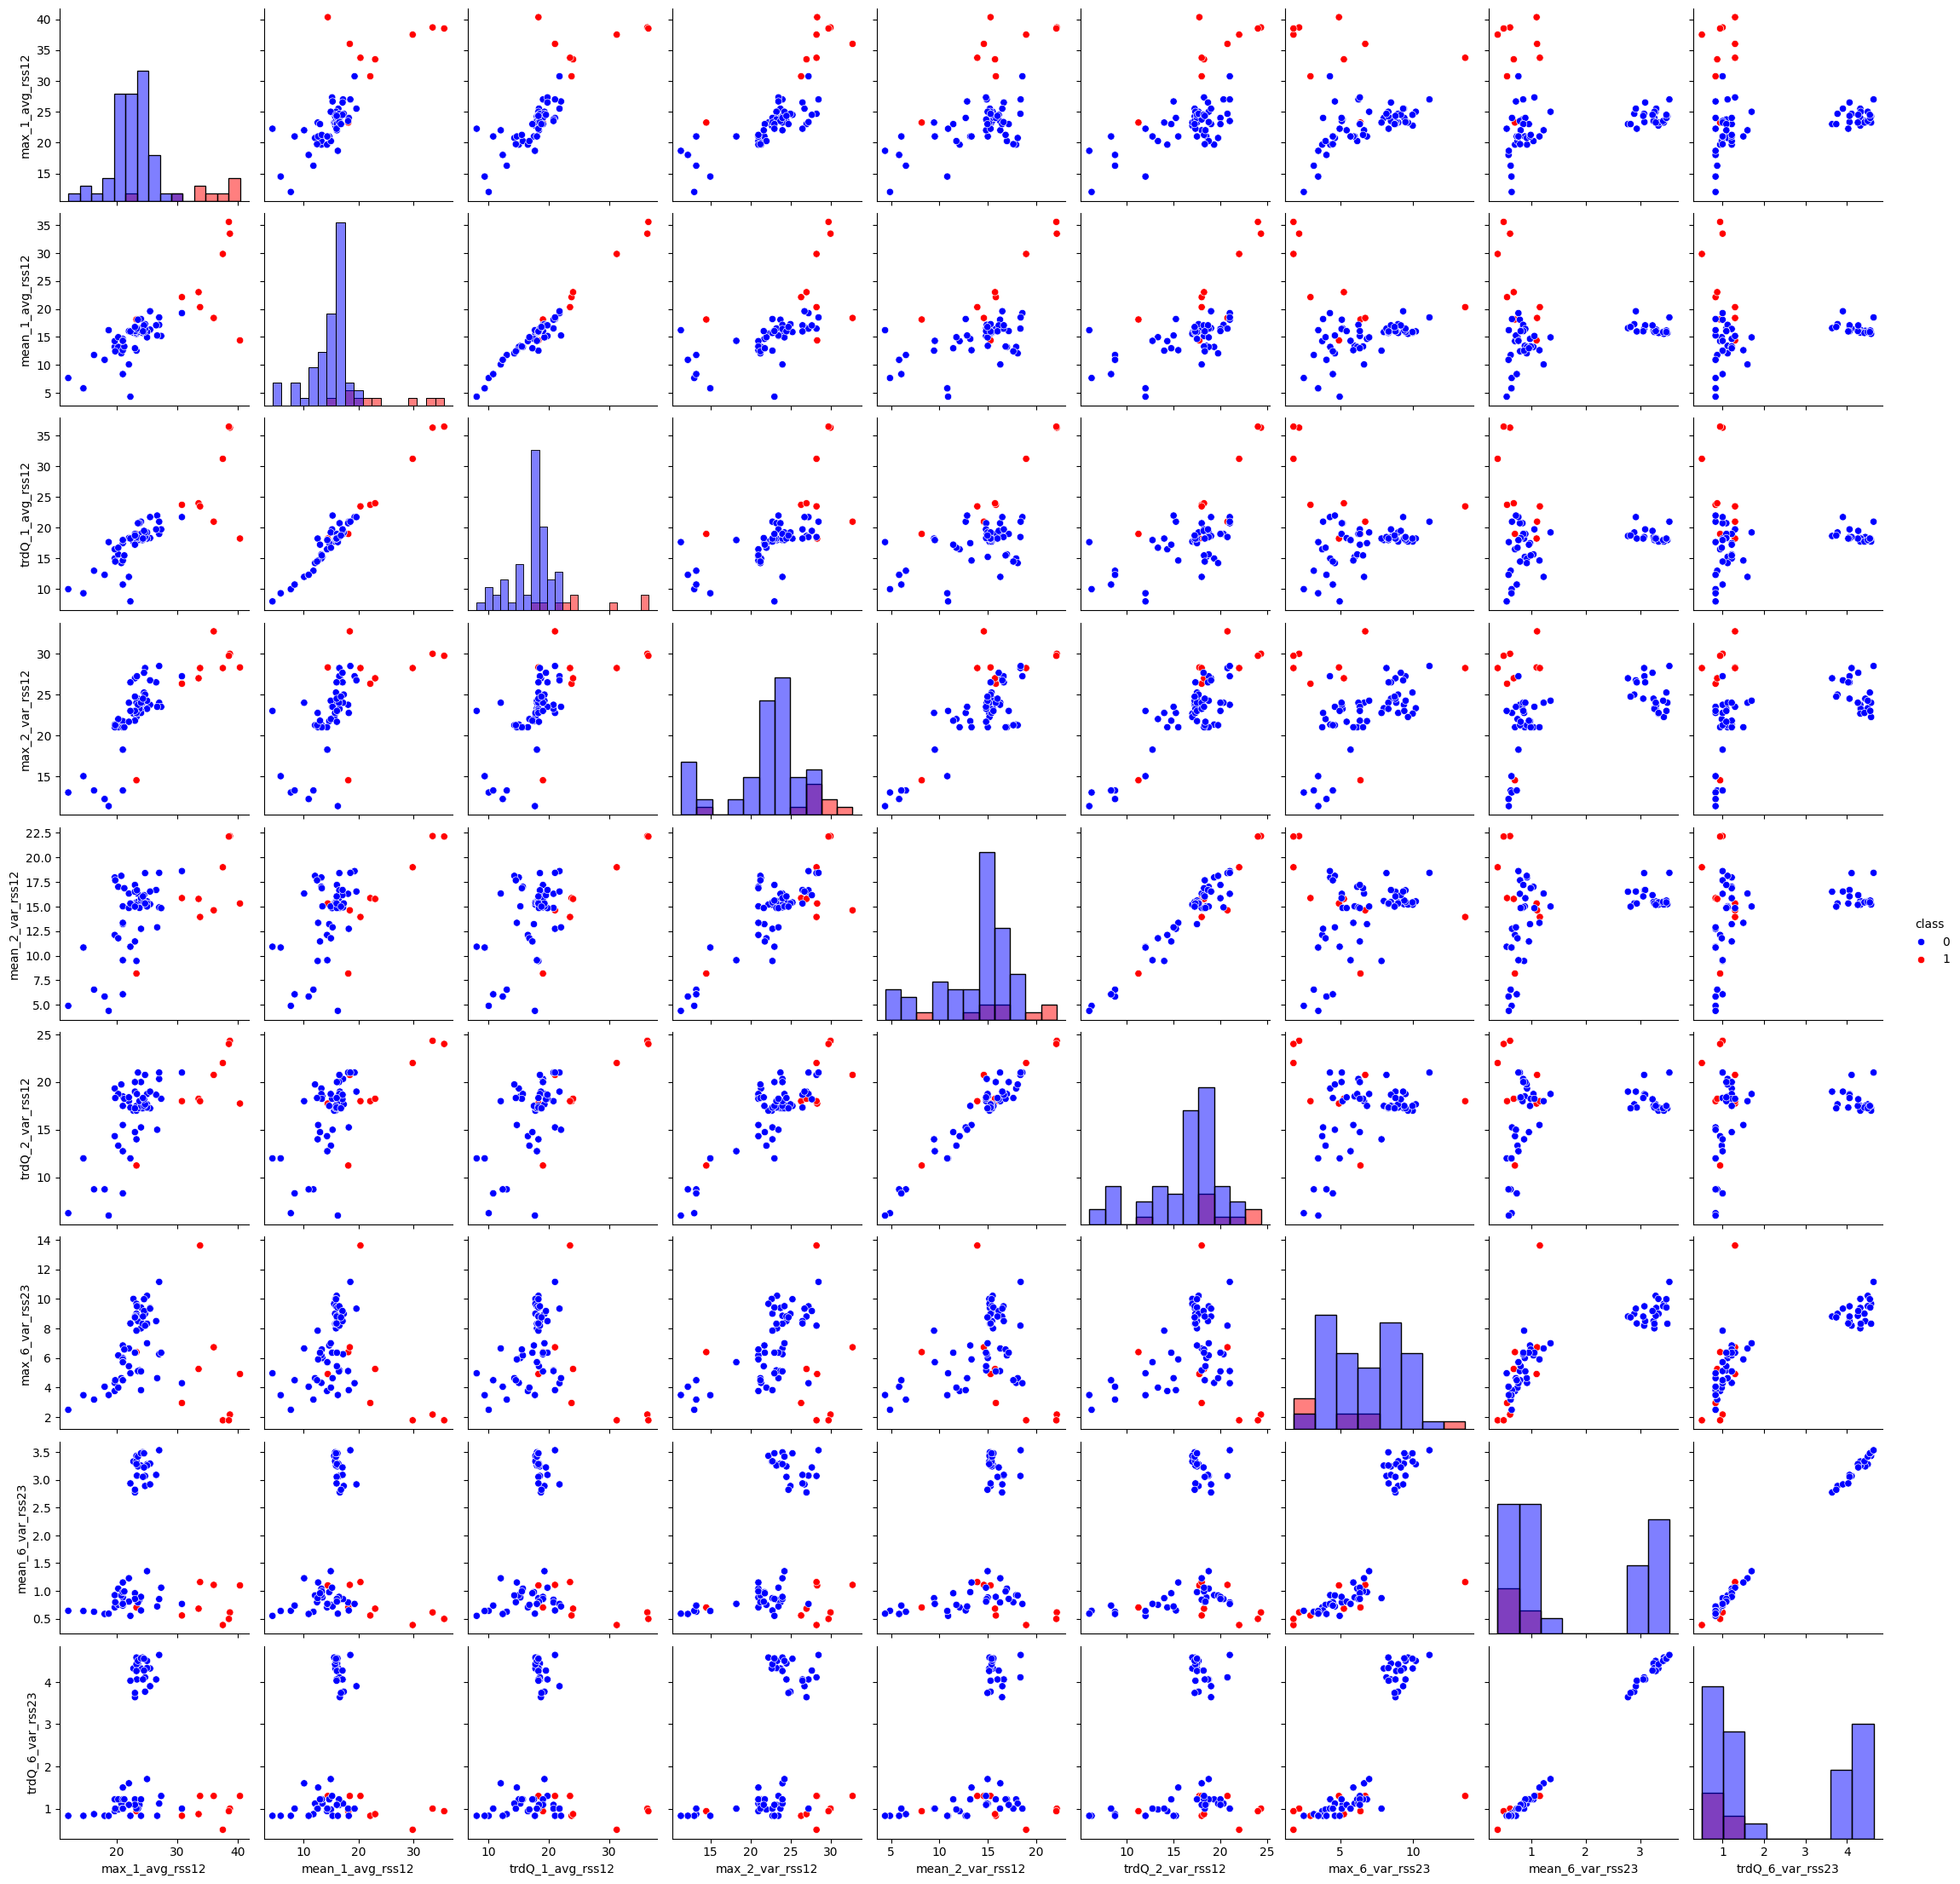

In [6]:
# chosen time series features  from  1(c)iv
chosen_features = ['max', 'trdQ', 'mean']    

features_for_scatter = []
for feature in all_features:
    if (any(x in feature for x in chosen_features) and any(x in feature for x in ['_1_', '_2_', '_6_'])):
        features_for_scatter.append(feature)

sns.pairplot(data=df_train, hue='class', vars = features_for_scatter, diag_kind='hist', palette=['blue', 'red'])

#### ii. Splitted Plots

In [7]:
def split_and_merge_TSdataset(df, l):
    # Split the dataset into l parts
    df_l = []
    split_length = len(df) // l
    for i in range(l):
        df_l.append(df.iloc[i*split_length: (i+1) * split_length])

    # # Concatenate the features from both parts vertically
    # for i in range(l):
    #     df_l[i] = df_l[i].drop(columns = ['time'])
    # return pd.concat([df_l[0], df_l[1]], axis=0)

    # Concatenate the features from both parts horizontally
    df_renamed = []
    for i in range(l):
        cur_df = df_l[i].drop(columns = ['time'])
        df_renamed.append(cur_df.add_suffix(f'_{i}'))
        # Resetting index to align the two dataframes
        df_renamed[i]= df_renamed[i].reset_index(drop=True)
    
    # Concatenate horizontally
    result = df_renamed[0]
    for i in range(1, l):
        result = pd.concat([result, df_renamed[i]], axis=1)
    
    return result

l = 2   # Time Series size
df_train_splitted = {}
for df_TS in df_train_dict:
    df_train_splitted[df_TS] = split_and_merge_TSdataset(df_train_dict[df_TS], l)

df_train_splitted[next(iter(df_train_splitted))].columns

Index(['avg_rss12_0', 'var_rss12_0', 'avg_rss13_0', 'var_rss13_0',
       'avg_rss23_0', 'var_rss23_0', 'avg_rss12_1', 'var_rss12_1',
       'avg_rss13_1', 'var_rss13_1', 'avg_rss23_1', 'var_rss23_1'],
      dtype='object')

In [8]:
# setup the feature names for new dataset we want
# TS_features = df_train_ori[0].columns # get feature names in original datset
def list_all_features(TS_features):
    all_features = []
    idx = 0
    for TS_feature in TS_features:
        idx += 1
        if TS_feature != 'time':
            # min_name = f'min_{idx}_'
            # all_features.append(min_name)
            max_name = f'max_{idx}_'
            all_features.append(max_name)
            mean_name = f'mean_{idx}_'
            all_features.append(mean_name)
            # median_name = f'median_{idx}_'
            # all_features.append(median_name)
            # std_name = f'std_{idx}_'
            # all_features.append(std_name)
            # fstQ_name = f'fstQ_{idx}_'
            # all_features.append(fstQ_name)
            trdQ_name = f'trdQ_{idx}_'
            all_features.append(trdQ_name)
    all_features.append("class")
    return all_features

chosen_features = ['max', 'trdQ', 'mean']    

def calculate_feature_values(df, isBending, chosen_features = chosen_features):
    data_point = []
    for feature in set(df.columns) - set(['time']):
        series_clean = np.array(df[feature])
        # series_clean = [x for x in series if not pd.isna(x)]
        # data_point.append(min(series_clean))
        data_point.append(max(series_clean))
        mean = statistics.mean(series_clean)
        data_point.append(mean)
        # median = statistics.median(series_clean)
        # data_point.append(median)
        # stdev = statistics.stdev(series_clean)
        # data_point.append(stdev)
        quartile = statistics.quantiles(series_clean, n=4)
        # data_point.append(quartile[0])
        data_point.append(quartile[2])

    data_point.append(isBending)
    return data_point

TS_features = df_train_splitted[next(iter(df_train_splitted))].columns
all_features = list_all_features(TS_features)
df_train = [] 
for df_TS in df_train_splitted:
    isBending = '1' if 'bending' in df_TS else '0'
    df_train.append(calculate_feature_values(df_train_splitted[df_TS], isBending))
df_train = pd.DataFrame(df_train,  columns = all_features)

df_train.columns    # check if successful

Index(['max_1_', 'mean_1_', 'trdQ_1_', 'max_2_', 'mean_2_', 'trdQ_2_',
       'max_3_', 'mean_3_', 'trdQ_3_', 'max_4_', 'mean_4_', 'trdQ_4_',
       'max_5_', 'mean_5_', 'trdQ_5_', 'max_6_', 'mean_6_', 'trdQ_6_',
       'max_7_', 'mean_7_', 'trdQ_7_', 'max_8_', 'mean_8_', 'trdQ_8_',
       'max_9_', 'mean_9_', 'trdQ_9_', 'max_10_', 'mean_10_', 'trdQ_10_',
       'max_11_', 'mean_11_', 'trdQ_11_', 'max_12_', 'mean_12_', 'trdQ_12_',
       'class'],
      dtype='object')

In [9]:
# # the first part of time series 1, 2 and 6
# features_for_scatter = []
# for feature in all_features:
#     if (any(x in feature for x in ['_1_', '_2_', '_6_'])):
#         features_for_scatter.append(feature)

# sns.pairplot(data=df_train, hue='class', vars = features_for_scatter, diag_kind='hist', palette=['red', 'blue'])

# # the second part of time series 1, 2 and 6
# features_for_scatter = []
# for feature in all_features:
#     if (any(x in feature for x in ['_7_', '_8_', '_12_'])):
#         features_for_scatter.append(feature)

# sns.pairplot(data=df_train, hue='class', vars = features_for_scatter, diag_kind='hist', palette=['red', 'blue'])

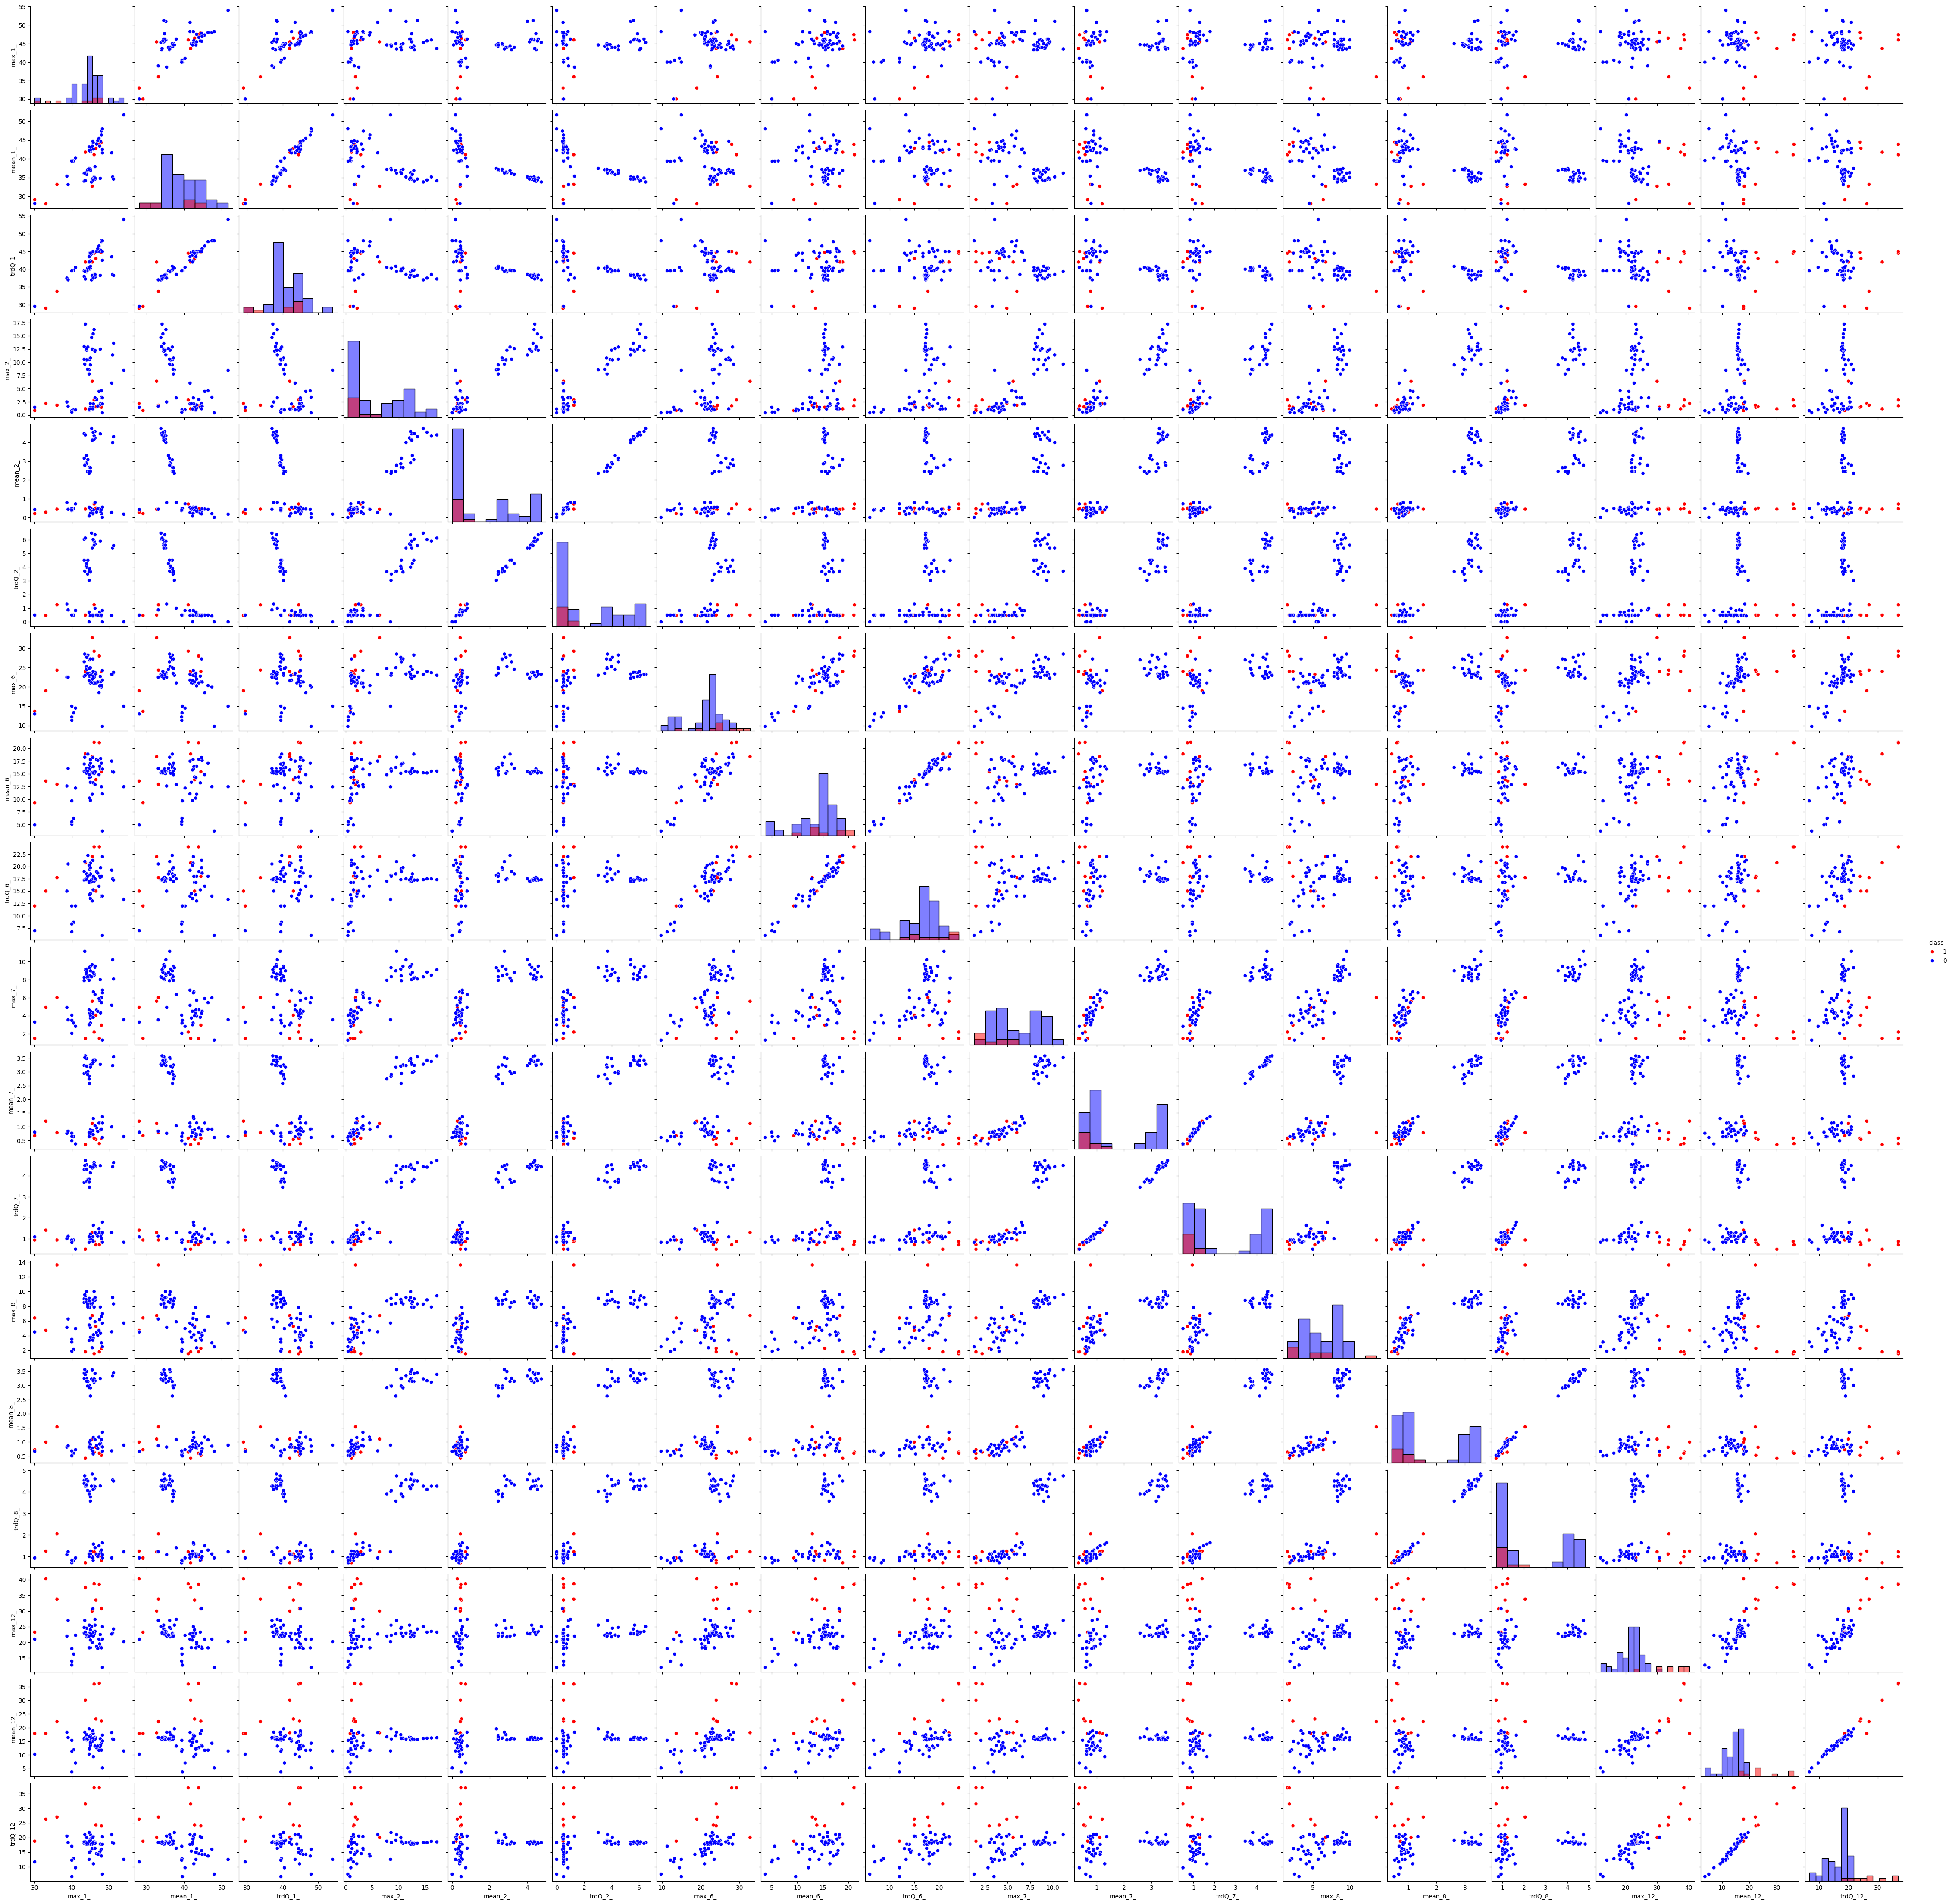

In [10]:
# compared together
features_for_scatter = []
for feature in all_features:
    if (any(x in feature for x in ['_1_', '_2_', '_6_', '_7_', '_8_', '_12_'])):
        features_for_scatter.append(feature)

sns.pairplot(data=df_train, hue='class', vars = features_for_scatter, diag_kind='hist', palette=['red', 'blue'])

##### Conclusion

There is **no** significant difference between the plots in 2.a.i and 2.a.ii

#### iii. Time Series Segments

**Split segments**: `l`    
(Original time series dataset is split into l segments)

**Time series data**:
88 instances in total. 
Here I only deal with the 69 training dataset. This meaning the data points / instance we'll have is 69.

**Time Domain features**:
In Q1 I decided the 3 best time domain features(max, trdQ and mean), so here we *won't* be calculating the other 4 time domain features.

Therefore, for split size = l, we'll have l * 6 * 3 features. When l = 20, we'll have 20 * 6 * 3 = 360 features.

---
Functions pre-defined: 

* `split_and_merge_TSdataset`
* `list_all_features`
* `calculate_feature_values`

---
**References**:
* [Understanding Logistic Regression in Python](https://www.datacamp.com/tutorial/understanding-logistic-regression-python)
* [Logistic Regression with StratifiedKfold](https://www.kaggle.com/code/sudhirnl7/logistic-regression-with-stratifiedkfold)
* [StackOverflow - Scikit-learn - feature reduction using RFECV and GridSearch](https://stackoverflow.com/questions/31059123/scikit-learn-feature-reduction-using-rfecv-and-gridsearch-where-are-the-coeff)
* [Recursive Feature Elimination (RFE): Working, Advantages & Examples](https://www.analyticsvidhya.com/blog/2023/05/recursive-feature-elimination/)
* [LogisticRegression Doc](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) 
-> Why I chose lbfgs
* [RFECV doc](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.RFECV.html)
* [StratifiedKFold Doc](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)


In [11]:
binary_class_dict = {1: 'bending', 0: 'non-bending'}
multi_classes_dict = {0: 'bending1', 1: 'bending2', 2: 'cycling', 3: 'lying', 4: 'sitting', 5: 'standing', 6: 'walking'}

In [12]:
# get dataset `df_train` after a l-segment split
def get_segmented_dataset(df_dict, l, isMulti=False):
    df_splitted = {}
    for df_TS in df_dict:
        df_splitted[df_TS] = split_and_merge_TSdataset(df_dict[df_TS], l)

    # print(df_splitted[next(iter(df_splitted))])
    TS_features = df_splitted[next(iter(df_splitted))].columns
    all_features = list_all_features(TS_features)
    df_train = [] 
    for df_TS in df_splitted:
        if isMulti:
            class_type = 0
            for i in range(0, 6):
                if multi_classes_dict[i] in df_TS:
                    class_type = i
                    break
        else:
            class_type = 1 if 'bending' in df_TS else 0
        df_train.append(calculate_feature_values(df_splitted[df_TS], class_type))
    df_train = pd.DataFrame(df_train, columns = all_features)
    
    return df_train


def oversample_imbalance_class(df):
    total0 = df.loc[df['class'] == 0].index.size
    total1 = df.loc[df['class'] == 1].index.size
    minor_label, major_label = (1, 0) if total0 > total1 else (0, 1)
        
    minor_ds = df[df['class'] == minor_label]
    major_ds = df[df['class'] == major_label]
    
    minor_ds = resample(minor_ds, replace = True, random_state = 60, n_samples = max(total0, total1))
    df = pd.concat([major_ds, minor_ds])
    return df

def logistic_regression(df_dict, l, cv_fold = 5, oversampling = False, penalty=None):
    # get df that's been segmented
    df = get_segmented_dataset(df_dict, l)

    # oversampling to prevent imbalance
    if oversampling: 
        df = oversample_imbalance_class(df)
    
    # spliting data to X and label Y
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # main model
    model = LogisticRegression(penalty = penalty, solver = 'lbfgs', max_iter = 100)
    cv = StratifiedKFold(n_splits = cv_fold, shuffle = True, random_state = len(df_train_dict))
    # Fit RFECV model using RFE and 5-fold stratified cross validation
    selector = RFECV(estimator = model, cv = cv, scoring = 'accuracy')
    selector.fit(X, y)
    
    accuracy = round(selector.cv_results_['mean_test_score'].max(), 5)
    
    return model, selector, accuracy, 1 - accuracy, df

In [13]:
# start looping through split size l = [1, 21)
LR_results = {'Split': [], '# Features': [], 'Score': [], 'Error': []}
for l in range(1, 21):  # l =  Time Series split size
    model, selector, score, error, _ = logistic_regression(df_train_dict, l)
    LR_results['Split'].append(l)
    LR_results['# Features'].append(selector.n_features_)
    LR_results['Score'].append(score)
    LR_results['Error'].append(error)

LR_results = pd.DataFrame(LR_results)
LR_results = LR_results.sort_values(by=['Error', 'Split'], ascending=[True, True])
LR_results

Split  # Features    Score    Error
0       1           5  0.98571  0.01429
2       3           4  0.98571  0.01429
4       5          18  0.98571  0.01429
10     11          66  0.98571  0.01429
12     13         228  0.98571  0.01429
13     14         196  0.98571  0.01429
14     15          74  0.98571  0.01429
15     16          93  0.98571  0.01429
16     17          78  0.98571  0.01429
17     18          97  0.98571  0.01429
18     19          84  0.98571  0.01429
19     20          89  0.98571  0.01429
1       2          25  0.97143  0.02857
3       4           4  0.97143  0.02857
5       6           3  0.97143  0.02857
6       7           1  0.97143  0.02857
7       8           9  0.97143  0.02857
8       9           3  0.97143  0.02857
9      10          31  0.97143  0.02857
11     12           2  0.97143  0.02857

##### Conclusions

I chose RFECV because it accounts to variability across all folds and selects optimal # of features that maximizes the cross validated score overall.

from the above results, we can quickly find the (l, p) pairs with the highest test score(i.e. lowest test error). Considering there are several pairs, we should choose the one with smaller splits to reduce the complexity of the model.

Therefore, the ideal pair is: **(3, 4)** 

l=3, #Features=4

#### iv. Confusion Matrix

In [14]:
# build model with selected best features
def build_model(df_dict, l, oversampling=False): 
    _, selector, _, _, df = logistic_regression(df_dict, l, oversampling=oversampling)
    # print(selector.n_features_)
    # print(selector.feature_names_in_)
    # print(selector.ranking_)
    # print(selector.support_)

    # get the features being selected from this regression
    selected_features = []
    for i in range(selector.n_features_in_):
        if selector.support_[i]:
            selected_features.append(selector.feature_names_in_[i])
    # print("selected_features: \n", selected_features, "\n")
    # selector

    # spliting data to X and label Y
    X, y = df.iloc[:, :-1], df.iloc[:, -1]

    X_best = X.loc[:, selected_features]

    # use statsmodel to do logistic regression so we can get a summary
    # of the selected features
    const_ = sm.add_constant(X_best.to_numpy(dtype = float))
    sm_model = sm.Logit(y.to_numpy(dtype = float), const_)
    summary = sm_model.fit(method = 'bfgs').summary()
    # Print the estimated parameters and p-values 
    print(summary)

    # use the same model `LR_model` defined in function `logistic_regression`
    # to get a RFE model
    # RFE_model = RFE(LR_model, n_features_to_select=selector.n_features_)
    # fit the RFE_model on training data
    # RFE_model.fit(X_best, y)
    # no need to re-train, we can just use selector return from `logistic regression`

    # re-train the RFE model 
    selector.fit(X_best, y)

    return selector, df, X_best, y, selected_features

model, df_train, X_train_best, y_train, selected_features \
    = build_model(df_train_dict, l=3)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       64
Method:                           MLE   Df Model:                            4
Date:                Sun, 20 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        07:38:36   Log-Likelihood:            -9.8775e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 6.909e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4340   3.42e+06   -4.

CONFUSION MATRIX: 
[[60  0]
 [ 0  9]]
Accuracy: 1.0


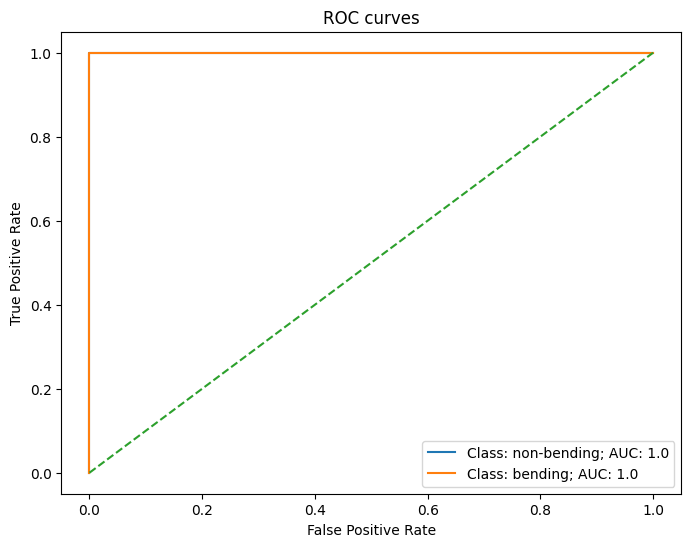

In [15]:
def print_CM_ROC(model, X, y):
    # make prediction
    y_pred = model.predict(X)

    # get confusion matrix
    model_cm = confusion_matrix(y, y_pred)
    print(f"CONFUSION MATRIX: \n{model_cm}")

    # get t score
    t_score = model.score(X, y)
    print(f"Accuracy: {t_score}")

    # Plot ROC curve and AUC score
    _, axes = plt.subplots(figsize = (8, 6))
    # Get the predicted probabilities
    y_prob = model.predict_proba(X)
    for i, class_ in enumerate(model.classes_):
        y_pred = y_prob[:, i]
        fpr, tpr, _ = roc_curve(y, y_pred, pos_label = class_)
        roc_auc = auc(fpr, tpr)
        if (model.classes_.size == 2):
            class_name = binary_class_dict[class_]
            axes.plot(fpr, tpr, label = f"Class: {class_name}; AUC: {round(roc_auc, 4)}")
        else: 
            class_name = multi_classes_dict[class_]
            axes.plot(fpr, tpr, label = f"Class: {class_name}; AUC: {round(roc_auc, 4)}")
    # plot AUC and ROC
    axes.set_title("ROC curves")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

    # # deprecated (can only be used in binary classification)
    # # Get the predicted probabilities 
    # y_pred_proba = model.predict_proba(X)
    # fpr, tpr, _ = roc_curve(y, y_pred_proba[:, 1])
    # roc_auc = auc(fpr, tpr)
    # plt.figure()
    # plt.plot(fpr, tpr, label='ROC (AUC = %0.2f)' % roc_auc)
    # plt.plot([0, 1], [0, 1],'r--')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curve')
    # plt.legend(loc="lower right")
    # plt.show()

print_CM_ROC(model, X_train_best, y_train)

##### Conclusion

The summary and ROC curve of logistic regression is as shown above. 

The p-values of all predictors is very close or equal to 1.0.
Given that, we cannot reject the null hypothesis $\beta_i = 0$, meaning the predictors are statistically insignificant.

#### v. Test Classifier

CONFUSION MATRIX: 
[[15  0]
 [ 0  4]]
Accuracy: 1.0


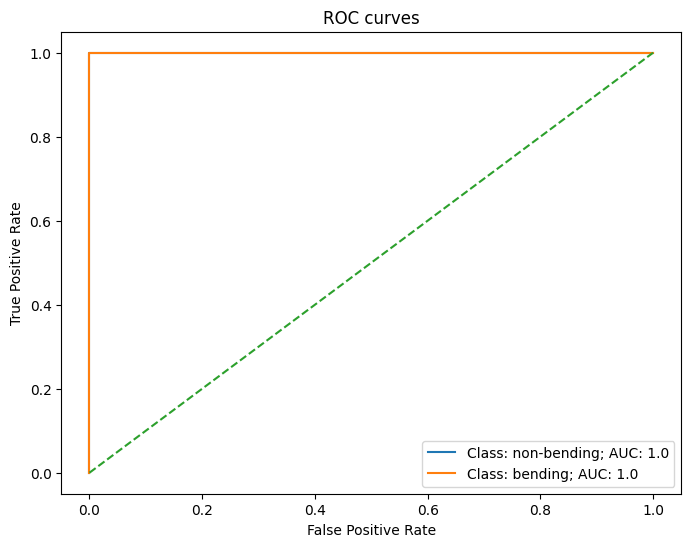

In [16]:
df_test = get_segmented_dataset(df_test_dict, l = 3)
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]

X_test_best = X_test.loc[:, selected_features]

print_CM_ROC(model, X_test_best, y_test)

* The accuracy for test and cross-validation are same.


#### vi. Separation

The p-value analysis using statmodel indicates good separation. In this case, the maximum likelihood estimator (MLE) does not exist and the parameters are not identified.

Therefore, good separation of the classes may lead to instability in the calculation of regression parameters.

#### vii. Imbalance

Yes, the class is imbalanced, as bending data has only 9 data points while non-bending data has 60.

In [17]:
# start looping through split size l = [1, 21)
LR_imbalance_results = {'Split': [], '# Features': [], 'Score': [], 'Error': []}
for l in range(1, 21):  # l =  Time Series split size
    LR_model, selector, score, error, _ = logistic_regression(df_train_dict, l, oversampling=True)
    LR_imbalance_results['Split'].append(l)
    LR_imbalance_results['# Features'].append(selector.n_features_)
    LR_imbalance_results['Score'].append(score)
    LR_imbalance_results['Error'].append(error)

LR_imbalance_results = pd.DataFrame(LR_imbalance_results)

In [18]:
LR_imbalance_results = LR_imbalance_results.sort_values(by=['Error', 'Split'], ascending=[True, True])
LR_imbalance_results

Split  # Features    Score    Error
0       1           5  1.00000  0.00000
8       9           3  1.00000  0.00000
3       4           6  0.99167  0.00833
4       5           3  0.99167  0.00833
5       6           2  0.99167  0.00833
6       7          31  0.99167  0.00833
7       8           3  0.99167  0.00833
9      10           4  0.99167  0.00833
10     11           4  0.99167  0.00833
11     12           2  0.99167  0.00833
12     13           4  0.99167  0.00833
13     14           2  0.99167  0.00833
14     15           5  0.99167  0.00833
15     16           2  0.99167  0.00833
16     17           4  0.99167  0.00833
17     18           2  0.99167  0.00833
18     19           2  0.99167  0.00833
19     20           2  0.99167  0.00833
1       2          11  0.98333  0.01667
2       3           3  0.98333  0.01667

Choose the (l, p) pair of **(1, 5)**.

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  120
Model:                          Logit   Df Residuals:                      114
Method:                           MLE   Df Model:                            5
Date:                Sun, 20 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        07:44:44   Log-Likelihood:            -3.0142e-05
converged:                       True   LL-Null:                       -83.178
Covariance Type:            nonrobust   LLR p-value:                 4.371e-34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9462   2.17e+05  -4.3

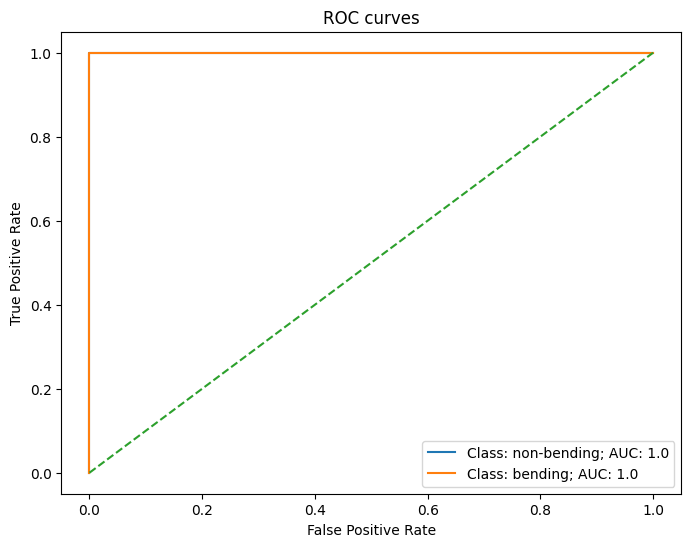

In [31]:
chosen_features = ['max', 'trdQ', 'mean']    
l = 1

# build the oversampling model with split l = 9
model_oversml, df_train_oversml, X_train_best_oversml, y_train_oversml, selected_features_oversml \
    = build_model(df_train_dict, l, oversampling=True)

    # print()
print("\n\nselected_features oversampling: \n", selected_features_oversml, "\n\n")

# get confusion matrix, ROC and AUC on training data
print("Report on training data: ")
print_CM_ROC(model_oversml, X_train_best_oversml, y_train_oversml)

Report on test data: 
CONFUSION MATRIX: 
[[0 5 0 0 0 0]
 [0 2 0 0 0 0]
 [0 3 0 0 0 0]
 [0 3 0 0 0 0]
 [0 3 0 0 0 0]
 [0 3 0 0 0 0]]
Accuracy: 0.10526315789473684


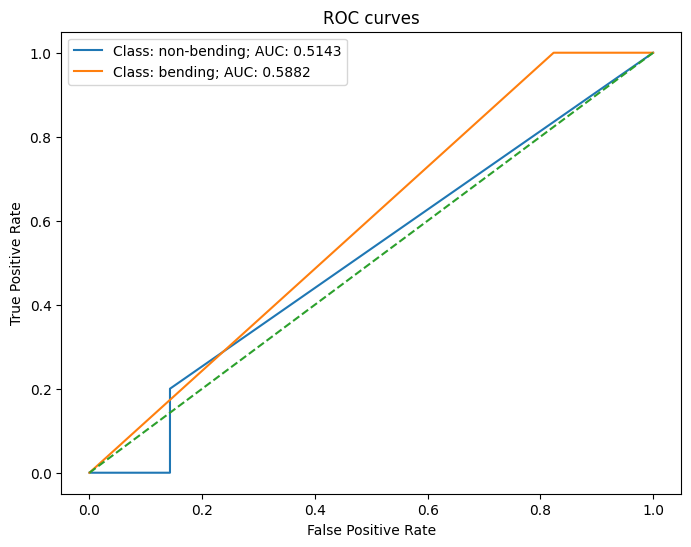

In [32]:
# get confusion matrix, ROC and AUC on test data
df_test_oversmpl = get_segmented_dataset(df_test_dict, l=9)
X_test_oversmpl, y_test_oversml = df_test_oversmpl.iloc[:, :-1], df_test.iloc[:, -1]

X_test_best_oversml = X_test_oversmpl.loc[:, selected_features_oversml]
print("Report on test data: ")
print_CM_ROC(model_oversml, X_test_best_oversml, y_test_oversml)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

**References**:

* [regularization strength logistic regression](https://medium.com/@rithpansanga/logistic-regression-and-regularization-avoiding-overfitting-and-improving-generalization-e9afdcddd09d) -> This explains *how to choose the regularization strength (hyperparameter)* and *How to implement logistic regression with regularization in python*

##### l = 2

**To Grader: You can skip this part:)**


First do a l = 2 split and write it in plain Python without functions.

In [21]:
# get and format training set
df_train = get_segmented_dataset(df_train_dict, l=2)
X_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1]

# # scale data
# scalar = StandardScaler()
# X_train_fit = scalar.fit_transform(X_train)
# explanation: I decided NOT to scale it, because the false negative cases in confusion matrix in test set is very high!

# fit logistic regression model
lr_model = LogisticRegressionCV(penalty = 'l1', solver="liblinear", cv=5, random_state=69)
lr_model.fit(X_train, y_train)

print("Best C (inversed value): ", lr_model.C_[0])
# print(lr_model.feature_names_in_)
# print(lr_model.Cs_)
# print(lr_model.scores_)
# print(lr_model.scores_[1][0])
df_lr_modelCV_L1_attr = pd.DataFrame({"Cs": lr_model.Cs_, "scores1": lr_model.scores_[1][0], "scores2": lr_model.scores_[1][1], "scores3": lr_model.scores_[1][2], "scores4": lr_model.scores_[1][3], "scores5": lr_model.scores_[1][4]})
df_lr_modelCV_L1_attr


Best C (inversed value):  0.046415888336127774


Cs   scores1   scores2   scores3   scores4   scores5
0      0.000100  0.857143  0.857143  0.857143  0.857143  0.923077
1      0.000774  0.857143  0.857143  0.857143  0.857143  0.923077
2      0.005995  0.857143  0.857143  0.857143  0.857143  0.923077
3      0.046416  0.857143  1.000000  1.000000  0.857143  1.000000
4      0.359381  0.857143  1.000000  0.857143  0.928571  1.000000
5      2.782559  0.857143  1.000000  0.857143  0.714286  1.000000
6     21.544347  0.857143  1.000000  0.857143  0.714286  1.000000
7    166.810054  0.857143  1.000000  0.785714  0.857143  0.923077
8   1291.549665  0.928571  1.000000  0.785714  0.928571  0.923077
9  10000.000000  0.928571  1.000000  0.714286  0.928571  0.923077

In [22]:
# find C with highest train scores
bestC = lr_model.C_[0]
bestC_idx = lr_model.Cs_.tolist().index(bestC)
print("bestC_idx: ", bestC_idx)

# get the highest mean of training scores
train_score = np.mean(lr_model.scores_[1][:, bestC_idx])
print("train_score: ", train_score)
# calculate train error
train_error = round((1 - train_score), 4)

# select features from the above lr model
# Get the coefficients
coefficients = lr_model.coef_
selected_features_idx = np.where(coefficients != 0)[1]
selected_features = X_train.columns[(selected_features_idx)]
print("selected_features: \n", selected_features)

bestC_idx:  3
train_score:  0.9428571428571428
selected_features: 
 Index(['max_1_', 'max_12_', 'mean_12_'], dtype='object')



Confusion Matrix of test set:
 [[15  0]
 [ 1  3]]


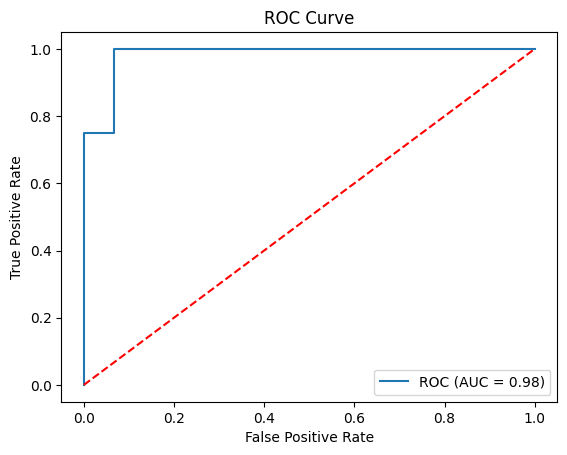

In [23]:
# predictions, and
# report CM and ROC on training & test data

# get and format test set
df_test = get_segmented_dataset(df_test_dict, l=2)
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]

# CM confusion matrix
y_test_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix of test set:\n {cm}")
# get AUC and ROC
y_train_prob = lr_model.predict_proba(X_train)
y_test_prob = lr_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
roc_auc = auc(fpr, tpr)
# plot AUC and ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### l = [1, 20]
Now wirte the above code into a function for looping when l = [1, 20]


In [24]:
# binary or multinomial (non-Naive-Bayes, L1-penalized)
def logistic_regression_penal(df_dict, l, isMulti=False):
    # get and format training set
    df = get_segmented_dataset(df_dict, l=l, isMulti=isMulti)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]

    # fit logistic regression model
    random_state = 69 #if isTrain else 19    # Em always True..
    solver = "saga" if isMulti else "liblinear"
    multi_class = "multinomial" if isMulti else "ovr"
    lr_model = LogisticRegressionCV(penalty = 'l1',
                                    solver=solver, 
                                    multi_class=multi_class,
                                    cv=5, random_state=random_state, max_iter=2000)
    lr_model.fit(X, y)

    # find C with highest train scores
    bestC = lr_model.C_[0]
    bestC_idx = lr_model.Cs_.tolist().index(bestC)

    # get the highest mean of training scores
    train_score = np.mean(lr_model.scores_[1][:, bestC_idx])
    # calculate train error
    train_error = round((1 - train_score), 4)

    return lr_model, df, train_score, train_error

# perform model with split l = [1, 20]
results = {"Split": [], '# features': [], 'Score': [], "Error": []}
for l in range(1, 21):
    model, _, train_score, train_error = logistic_regression_penal(df_train_dict, l)
    no_features = sum(1 for x in model.coef_[0] if x != 0)
    results["Split"].append(l)
    results["# features"].append(no_features)
    results['Score'].append(train_score)
    results["Error"].append(train_error)
results = pd.DataFrame(results)
results = results.sort_values(by=['Error', 'Split'], ascending=[True, True])
results

Split  # features     Score   Error
0       1           4  0.971429  0.0286
6       7          10  0.971429  0.0286
2       3           8  0.957143  0.0429
4       5           9  0.957143  0.0429
7       8          11  0.957143  0.0429
9      10           4  0.957143  0.0429
11     12           4  0.957143  0.0429
13     14           3  0.957143  0.0429
15     16           6  0.957143  0.0429
16     17           3  0.957143  0.0429
17     18           3  0.957143  0.0429
18     19           4  0.957143  0.0429
19     20           6  0.957143  0.0429
1       2           3  0.942857  0.0571
3       4           9  0.942857  0.0571
5       6          10  0.942857  0.0571
8       9           8  0.942857  0.0571
10     11           4  0.942857  0.0571
12     13           4  0.942857  0.0571
14     15           5  0.942857  0.0571

We'll use the (l, p) pair of **(1, 4)** to build model and use on test data.

selected_features: 
 Index(['max_1_', 'trdQ_4_', 'max_6_', 'mean_6_'], dtype='object') 

CONFUSION MATRIX: 
[[60  0]
 [ 0  9]]
Accuracy: 1.0


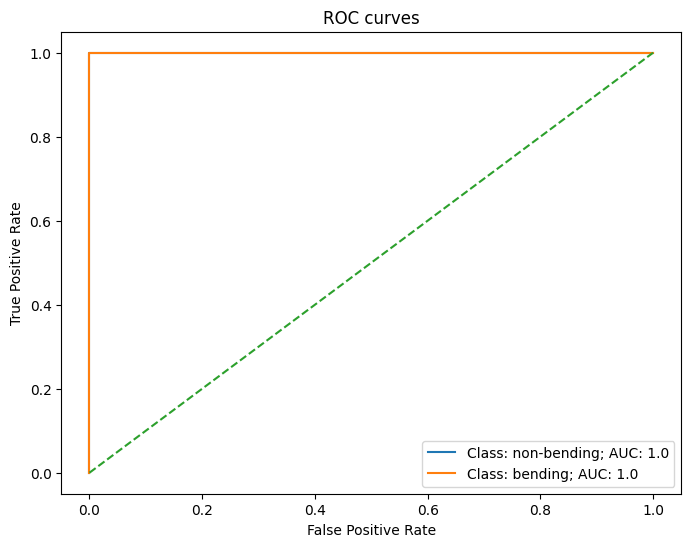

CONFUSION MATRIX: 
[[15  0]
 [ 0  4]]
Accuracy: 1.0


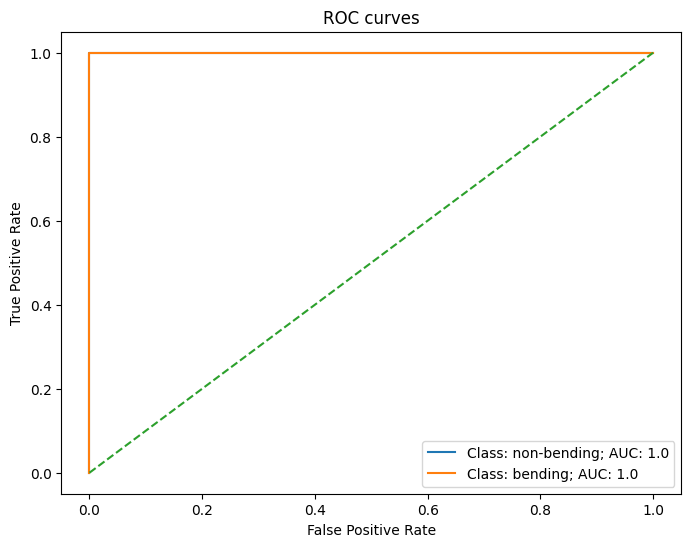

In [25]:
# build model
def build_model_penal(df_dict, l, isMulti=False):
    model, df, _, _ = logistic_regression_penal(df_dict, l=l, isMulti=isMulti)
    # spliting data to X and label Y
    X, y = df.iloc[:, :-1], df.iloc[:, -1]

    # select features from the above lr model
    # Get the coefficients
    coefficients = model.coef_
    selected_features_idx = np.where(coefficients != 0)[1]
    selected_features = X.columns[(selected_features_idx)]

    return model, X, y, selected_features

# report cm, AUC and ROC
l = int(results.iloc[0, 0])
# on traaining set
model, X_train, y_train, selected_features = build_model_penal(df_train_dict, l=l)
print("selected_features: \n", selected_features, "\n")
print_CM_ROC(model, X_train, y_train)

# on test set
df_test = get_segmented_dataset(df_test_dict, l = l)
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]
# X_test_best = X_test.loc[:, selected_features]

print_CM_ROC(model, X_test, y_test)


#### ii. Comparison

**Performance**
* The two logistic regression have the same perforance on test data set, with Accuracy of 1.0. 
* The one without L1-penalized term performs slitly better on training set (1.0 > 0.971429) but We don't take that into consideration since it's on training set. It might be because of overfitting, but they have the same performace on test set so that means we cannot see any sign of overfitting.


**Implementaiton**
* The L1-penalized logistic regression is easier to implement, because we don't have to manually find the hyperparameters.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [26]:
# check
# model, _, train_score, train_error = logistic_regression_penal(df_train_dict, l=3, isMulti=True)

# perform model with split l = [1, 20]
results_Multi = {"Split": [], '# features': [], 'Score': [], "Error": []}
for l in range(1, 21):
    model, _, train_score, train_error = logistic_regression_penal(df_train_dict, l, isMulti=True)
    no_features = sum(1 for x in model.coef_[0] if x != 0)
    results_Multi["Split"].append(l)
    results_Multi["# features"].append(no_features)
    results_Multi['Score'].append(train_score)
    results_Multi["Error"].append(train_error)
results_Multi = pd.DataFrame(results_Multi)
results_Multi = results_Multi.sort_values(by=['Error', 'Split'], ascending=[True, True])
results_Multi


Split  # features     Score   Error
0       1          12  0.827473  0.1725
3       4          47  0.797802  0.2022
1       2          20  0.783516  0.2165
8       9         159  0.770330  0.2297
6       7          95  0.754945  0.2451
4       5          90  0.752747  0.2473
2       3          15  0.740659  0.2593
5       6          77  0.740659  0.2593
16     17         225  0.739560  0.2604
7       8         112  0.725275  0.2747
10     11         138  0.725275  0.2747
11     12         141  0.725275  0.2747
13     14         179  0.725275  0.2747
19     20         253  0.712088  0.2879
18     19         233  0.710989  0.2890
14     15         191  0.709890  0.2901
9      10         177  0.696703  0.3033
17     18         232  0.696703  0.3033
15     16          67  0.681319  0.3187
12     13         159  0.680220  0.3198

selected_features: 
 Index(['max_1_', 'mean_1_', 'trdQ_1_', 'max_2_', 'max_3_', 'max_4_', 'trdQ_4_',
       'max_5_', 'mean_5_', 'trdQ_5_', 'max_6_', 'mean_6_', 'max_3_',
       'mean_4_', 'trdQ_4_', 'mean_5_', 'max_6_', 'mean_6_', 'trdQ_6_',
       'max_1_', 'max_2_', 'mean_2_', 'trdQ_2_', 'max_3_', 'mean_3_',
       'trdQ_3_', 'max_4_', 'mean_4_', 'trdQ_4_', 'max_5_', 'mean_5_',
       'max_6_', 'max_3_', 'max_4_', 'mean_4_', 'trdQ_4_', 'max_5_', 'mean_5_',
       'trdQ_5_', 'max_6_', 'mean_6_', 'trdQ_6_', 'max_1_', 'mean_1_',
       'trdQ_1_', 'max_2_', 'trdQ_2_', 'max_3_', 'trdQ_3_', 'max_4_',
       'mean_4_', 'trdQ_4_', 'mean_5_', 'trdQ_5_', 'max_6_', 'mean_6_',
       'trdQ_6_', 'max_1_', 'max_2_', 'max_3_', 'max_4_', 'mean_4_', 'trdQ_4_',
       'mean_5_', 'trdQ_5_', 'max_6_', 'mean_6_', 'trdQ_6_'],
      dtype='object') 

CONFUSION MATRIX: 
[[17  0  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]
Accuracy: 1

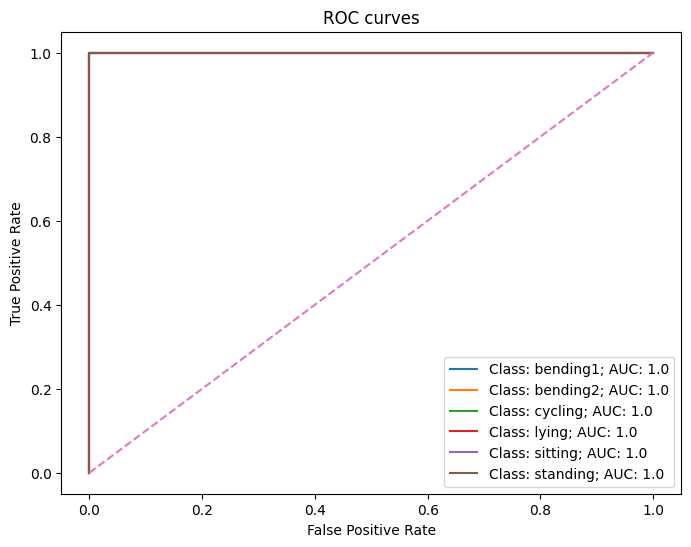

CONFUSION MATRIX: 
[[5 0 0 0 0 0]
 [1 0 1 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 1 0 2]]
Accuracy: 0.8421052631578947


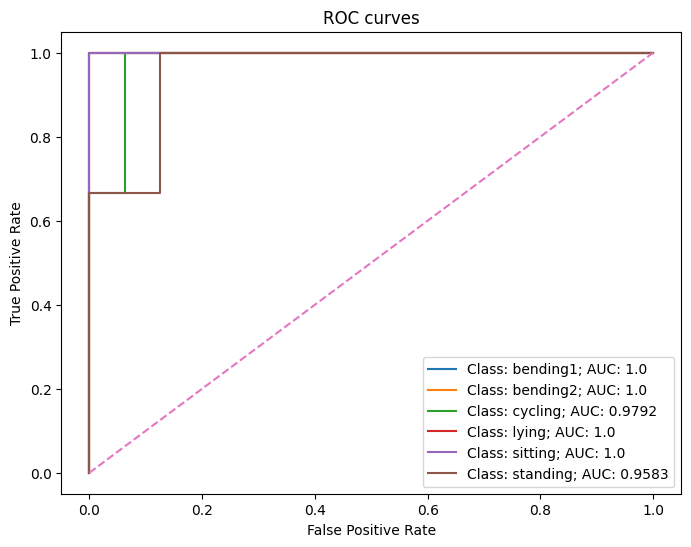

In [27]:
# best (l, p) pair
l = int(results_Multi.iloc[0, 0])
# p = int(results_Multi.iloc[0, 1])

# report cm, AUC and ROC
# on traaining set
model_multi, X_train, y_train, selected_features = build_model_penal(df_train_dict, l=l, isMulti=True)
print("selected_features: \n", selected_features, "\n")
print_CM_ROC(model_multi, X_train, y_train)

# on test set
df_test = get_segmented_dataset(df_test_dict, l = l, isMulti=True)
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]
X_test_best = X_test.loc[:, selected_features]

print_CM_ROC(model_multi, X_test, y_test)


#### ii. Naive Bayes

In [28]:
def logistic_regression_Bayes(df_dict, l, isGaussian=False, isMultinomialPrior=False, do_fit=False):
    # get and format training set
    df = get_segmented_dataset(df_dict, l=l, isMulti=True)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    
    # gaussian (Naive-Bayes)
    if isGaussian:
        model = GaussianNB()
    # Multinomial Prior (Naive-Bayes)
    elif isMultinomialPrior:
        model = MultinomialNB()
    else:
        raise Exception("Please select either Gaussian or Multinomail prior") 
    # CV
    score = cross_val_score(estimator = model,X = X, y = y, 
                            cv = StratifiedKFold(random_state = 0, shuffle = True), 
                            scoring = "accuracy")
    train_score = np.mean(score)
    # calculate train error
    train_error = round((1 - train_score), 4)
    #fit model
    if do_fit:
        model.fit(X, y)
    return model, df, train_score, train_error

# check
model, _, train_score, train_error = logistic_regression_Bayes(df_train_dict, l=1, isGaussian=True)

##### Gaussian

number of splits (Gaussian) : 2
Report on Training set:

CONFUSION MATRIX: 
[[15  0  0  0  2  0]
 [ 0  3  0  1  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]
Accuracy: 0.9565217391304348


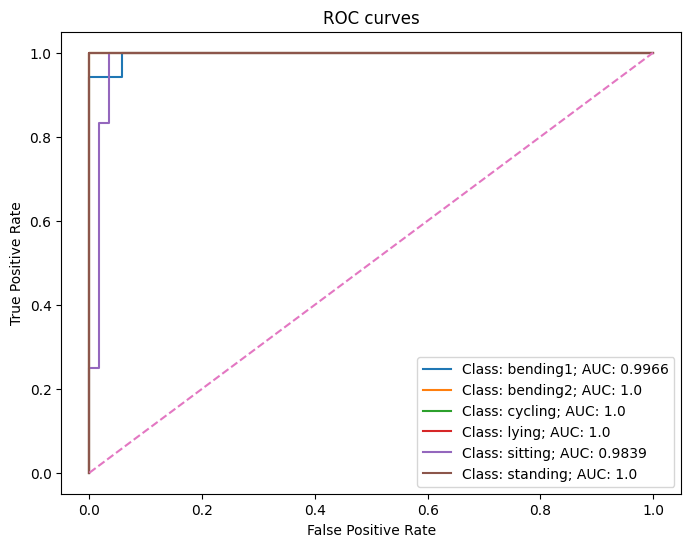

Report on Test set:

CONFUSION MATRIX: 
[[5 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 1 2]]
Accuracy: 0.9473684210526315


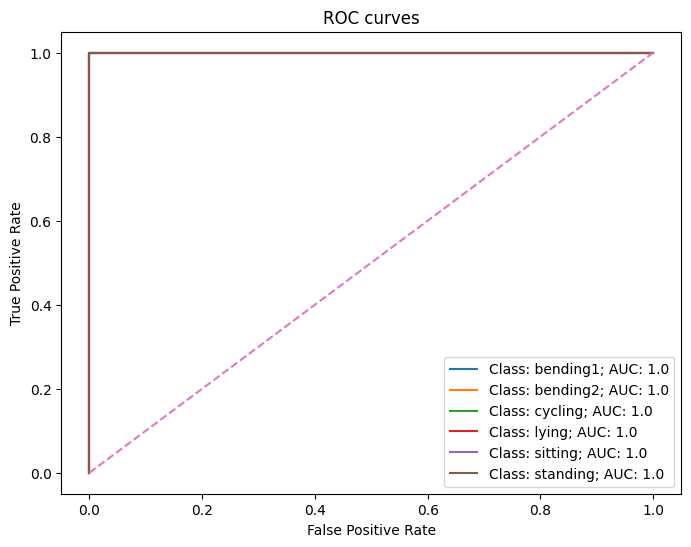

In [33]:
# perform Gaussian model with split l = [1, 20]
results = {"Split": [], 'Score': [], "Error": []}
for l in range(1, 21):
    _, _, train_score, train_error = logistic_regression_Bayes(df_train_dict, l=l, isGaussian=True)
    results["Split"].append(l)
    results['Score'].append(train_score)
    results["Error"].append(train_error)
results = pd.DataFrame(results)
results = results.sort_values(by=['Error', 'Split'], ascending=[True, True])
results

# best l
l = int(results.iloc[0, 0])
print("number of splits (Gaussian) :", l)
# build model
model, df_train, _, _ = logistic_regression_Bayes(df_train_dict, l=l, isGaussian=True, do_fit=True)

# report cm, AUC and ROC
# on traaining set
print("Report on Training set:\n")
X_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1]
print_CM_ROC(model, X_train, y_train)

# on test set
print("Report on Test set:\n")
df_test = get_segmented_dataset(df_test_dict, l = l, isMulti=True)
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]

print_CM_ROC(model, X_test, y_test)

##### Multinomial Prior

number of splits (Multinomial Prior) : 4
Report on Training set:

CONFUSION MATRIX: 
[[ 0  3 12  0  2  0]
 [ 0  3  0  0  1  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  1 11]]
Accuracy: 0.7246376811594203


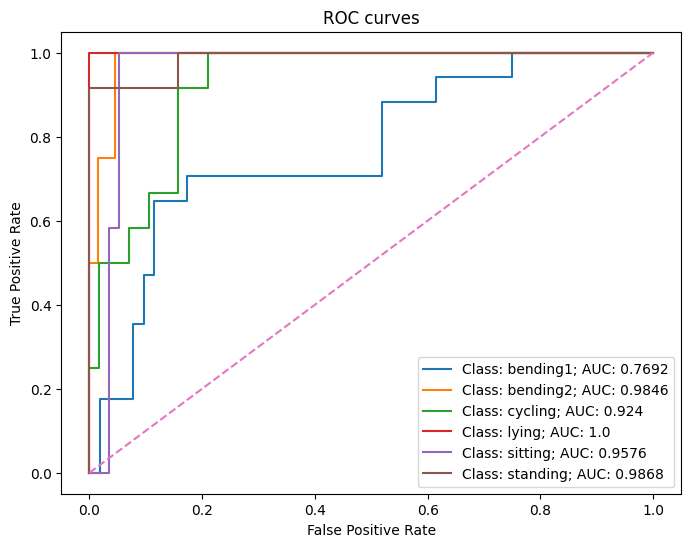

Report on Test set:

CONFUSION MATRIX: 
[[0 2 3 0 0 0]
 [0 2 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 2 1]
 [0 0 0 0 0 3]]
Accuracy: 0.6842105263157895


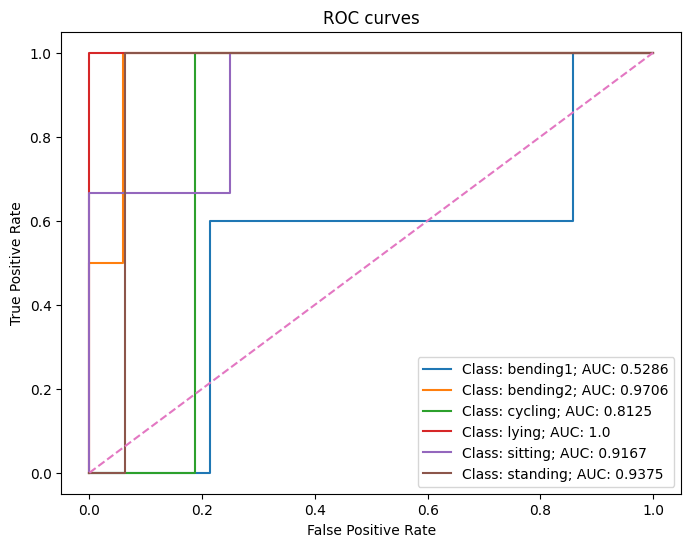

In [34]:
# perform Multinomial Prior model with split l = [1, 20]
results = {"Split": [], 'Score': [], "Error": []}
for l in range(1, 21):
    _, _, train_score, train_error = logistic_regression_Bayes(df_train_dict, l=l, isMultinomialPrior=True)
    results["Split"].append(l)
    results['Score'].append(train_score)
    results["Error"].append(train_error)
results = pd.DataFrame(results)
results = results.sort_values(by=['Error', 'Split'], ascending=[True, True])
results

# best l
l = int(results.iloc[0, 0])
print("number of splits (Multinomial Prior) :", l)
# build model
model, df_train, _, _ = logistic_regression_Bayes(df_train_dict, l=l, isMultinomialPrior=True, do_fit=True)

# report cm, AUC and ROC
# on traaining set
print("Report on Training set:\n")
X_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1]
print_CM_ROC(model, X_train, y_train)

# on test set
print("Report on Test set:\n")
df_test = get_segmented_dataset(df_test_dict, l = l, isMulti=True)
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]

print_CM_ROC(model, X_test, y_test)

#### iii. Comparison

1. Test set accuracy score comparison:

    Multinomial without Bayes score: 0.8421052631578947

    Gaussian score: 0.9473684210526315

    Multinomial Prior: 0.6842105263157895

    Gaussian score = Multinomial Prior score


2. best l Comparison:

    Gaussian: 2

    Multinomial Prior: 4

    Gaussian l < Multinomial Prior l

**Conclusion:**

**Gaussian** is better for for multi-class classification in this problem


## 3. ISLR 4.8.3

![image](./3.jpg)

## 4. ISLR 4.8.7

![image](./4.jpg)


## References

* [Understanding Logistic Regression in Python](https://www.datacamp.com/tutorial/understanding-logistic-regression-python)
* [Logistic Regression with StratifiedKfold](https://www.kaggle.com/code/sudhirnl7/logistic-regression-with-stratifiedkfold)
* [StackOverflow - Scikit-learn - feature reduction using RFECV and GridSearch](https://stackoverflow.com/questions/31059123/scikit-learn-feature-reduction-using-rfecv-and-gridsearch-where-are-the-coeff)
* [Recursive Feature Elimination (RFE): Working, Advantages & Examples](https://www.analyticsvidhya.com/blog/2023/05/recursive-feature-elimination/)
* [LogisticRegression Doc](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) 
-> How to choose solver
* [RFECV doc](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.RFECV.html)
* [StratifiedKFold Doc](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

* [regularization strength logistic regression](https://medium.com/@rithpansanga/logistic-regression-and-regularization-avoiding-overfitting-and-improving-generalization-e9afdcddd09d) -> This explains *how to choose the regularization strength (hyperparameter)* and *How to implement logistic regression with regularization in python*

* [LogisticRegressionCV Doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

* [GaussianNB Doc](https://scikit-learn.org/1.5/modules/generated/sklearn.naive_bayes.GaussianNB.html)

* [MultinomialNB Doc](https://scikit-learn.org/dev/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

* [SelectFromModel Doc](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)